This Notebook contains a GAN that attempts to generate handwritten digits using the MNIST database.
Adapted from https://github.com/uclaacmai/Generative-Adversarial-Network-Tutorial.
The comments are mostly mine and reflect my understanding.

In [1]:
import tensorflow as tf
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

c:\users\tyler\anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#MNIST is a classic handwriting database
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
#Extracts the 55,000 images from MNIST (disregarding labels)
#Each image is 28x28 pixels, thus the 784
x_train = mnist.train.images[:55000,:]
x_train.shape

(55000, 784)

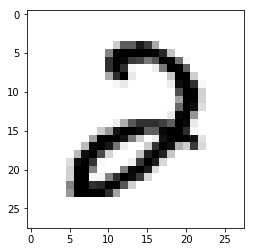

In [4]:
#Let's print a random digit
randomNum = random.randint(0,55000)
image = x_train[randomNum].reshape([28,28])
plt.imshow(image, cmap=plt.get_cmap('gray_r'))
plt.show()

In [5]:
#Helper function for convolutions
#x is the input image and W is the filter
def conv2d(x, W):
    return tf.nn.conv2d(input=x, filter=W, strides=[1, 1, 1, 1], padding='SAME')

#Helper function for poolings
#x is the input image
def avg_pool_2x2(x):
    return tf.nn.avg_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [6]:
#Convolutional neural network that determines if an input image is from MNIST
#Two Conv/Pool Layers followed by two FC layers and output layer
def discriminator(x_image, reuse=False):
    #Allows sharing of variables
    with tf.variable_scope('discriminator') as scope:
        if (reuse):
            tf.get_variable_scope().reuse_variables()
            
        #First Conv and Pool Layers
        W_conv1 = tf.get_variable('d_wconv1', [5, 5, 1, 8], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_conv1 = tf.get_variable('d_bconv1', [8], initializer=tf.constant_initializer(0))
        h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
        h_pool1 = avg_pool_2x2(h_conv1)

        #Second Conv and Pool Layers
        W_conv2 = tf.get_variable('d_wconv2', [5, 5, 8, 16], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_conv2 = tf.get_variable('d_bconv2', [16], initializer=tf.constant_initializer(0))
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
        h_pool2 = avg_pool_2x2(h_conv2)

        #First Fully Connected Layer
        W_fc1 = tf.get_variable('d_wfc1', [7 * 7 * 16, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_fc1 = tf.get_variable('d_bfc1', [32], initializer=tf.constant_initializer(0))
        h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*16])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

        #Second Fully Connected Layer
        W_fc2 = tf.get_variable('d_wfc2', [32, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_fc2 = tf.get_variable('d_bfc2', [1], initializer=tf.constant_initializer(0))

        #Final Layer
        y_conv=(tf.matmul(h_fc1, W_fc2) + b_fc2)
    return y_conv

In [7]:
#Deconvolutional neural network that takes noise and upscales it to a 28x28 image
def generator(z, batch_size, z_dim, reuse=False):
    #Allows sharing of variables
    with tf.variable_scope('generator') as scope:
        if (reuse):
            tf.get_variable_scope().reuse_variables()
            
        #Number of filters of first layer of generator 
        g_dim = 64
        #Color dimension of output (MNIST is grayscale, so c_dim = 1)
        c_dim = 1
        #Output size of the image
        s = 28
        #We want to slowly upscale the image, so these values will help make that change gradual
        s2, s4, s8, s16 = int(s/2), int(s/4), int(s/8), int(s/16)

        h0 = tf.reshape(z, [batch_size, s16+1, s16+1, 25])
        h0 = tf.nn.relu(h0)
        #Dimensions of h0 = batch_size x 2 x 2 x 25

        #First DeConv Layer
        output1_shape = [batch_size, s8, s8, g_dim*4]
        W_conv1 = tf.get_variable('g_wconv1', [5, 5, output1_shape[-1], int(h0.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv1 = tf.get_variable('g_bconv1', [output1_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv1 = tf.nn.conv2d_transpose(h0, W_conv1, output_shape=output1_shape, 
                                         strides=[1, 2, 2, 1], padding='SAME') + b_conv1
        H_conv1 = tf.contrib.layers.batch_norm(inputs = H_conv1, center=True, scale=True, is_training=True, scope="g_bn1")
        H_conv1 = tf.nn.relu(H_conv1)
        #Dimensions of H_conv1 = batch_size x 3 x 3 x 256

        #Second DeConv Layer
        output2_shape = [batch_size, s4 - 1, s4 - 1, g_dim*2]
        W_conv2 = tf.get_variable('g_wconv2', [5, 5, output2_shape[-1], int(H_conv1.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv2 = tf.get_variable('g_bconv2', [output2_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv2 = tf.nn.conv2d_transpose(H_conv1, W_conv2, output_shape=output2_shape, 
                                         strides=[1, 2, 2, 1], padding='SAME') + b_conv2
        H_conv2 = tf.contrib.layers.batch_norm(inputs = H_conv2, center=True, scale=True, is_training=True, scope="g_bn2")
        H_conv2 = tf.nn.relu(H_conv2)
        #Dimensions of H_conv2 = batch_size x 6 x 6 x 128

        #Third DeConv Layer
        output3_shape = [batch_size, s2 - 2, s2 - 2, g_dim*1]
        W_conv3 = tf.get_variable('g_wconv3', [5, 5, output3_shape[-1], int(H_conv2.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv3 = tf.get_variable('g_bconv3', [output3_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv3 = tf.nn.conv2d_transpose(H_conv2, W_conv3, output_shape=output3_shape, 
                                         strides=[1, 2, 2, 1], padding='SAME') + b_conv3
        H_conv3 = tf.contrib.layers.batch_norm(inputs = H_conv3, center=True, scale=True, is_training=True, scope="g_bn3")
        H_conv3 = tf.nn.relu(H_conv3)
        #Dimensions of H_conv3 = batch_size x 12 x 12 x 64

        #Fourth DeConv Layer
        output4_shape = [batch_size, s, s, c_dim]
        W_conv4 = tf.get_variable('g_wconv4', [5, 5, output4_shape[-1], int(H_conv3.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv4 = tf.get_variable('g_bconv4', [output4_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv4 = tf.nn.conv2d_transpose(H_conv3, W_conv4, output_shape=output4_shape, 
                                         strides=[1, 2, 2, 1], padding='VALID') + b_conv4
        H_conv4 = tf.nn.tanh(H_conv4)
        #Dimensions of H_conv4 = batch_size x 28 x 28 x 1

    return H_conv4

In [8]:
#Start a new TF session
sess = tf.Session()
#Noise vector has z-dim of 100
z_dimensions = 100
#Create a placeholder to act as a variable representing noise vector
#We use 'NONE' to placehold for batch size, which is set later
z_test_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])

In [9]:
#Create a variable that holds the output of the generator
sample_image = generator(z_test_placeholder, 1, z_dimensions)
#Set the noise vector using a Gaussian distribution
#The noise vector is a 1x100 vector
test_z = np.random.normal(-1, 1, [1,z_dimensions])

In [10]:
#Run the TF session
sess.run(tf.global_variables_initializer())
#Get the output of the generator where the placeholder
#is set to the randomized noise vector from above
temp = sess.run(sample_image, feed_dict={z_test_placeholder: test_z})

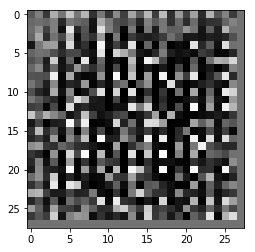

In [11]:
#Remove dimensions of size 1
#i.e. remove the z-axis so we can display as a planar image
my_i = temp.squeeze()
#Plot the generated image in grayscale
plt.imshow(my_i, cmap='gray_r')
plt.show()

In [12]:
#We'll set batch size to 16 for a good balance between speed and gradient accuracy
batch_size = 16
#Changing the batch size means we have to reset our TF defaults
tf.reset_default_graph()

#Start a new TF session
sess = tf.Session()

#Placeholder representing MNIST image tensor
x_placeholder = tf.placeholder("float", shape = [None, 28, 28, 1])
#Placeholder representing noise vector
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])

In [13]:
#Discriminator value for the MNIST image tensor
Dx = discriminator(x_placeholder)
#Generated image from the noise vector
Gz = generator(z_placeholder, batch_size, z_dimensions)
#Discriminator value for the generated image tensor
Dg = discriminator(Gz, reuse=True)

In [14]:
#Generator wants discriminator to return 1
#So we'll measure the loss between Dg and 1
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.ones_like(Dg)))

#Discriminator wants to get the correct labels (1 for MNIST or 0 for Dg)
#First one measures the loss between Dx and 1
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dx, labels = tf.ones_like(Dx)))
#Second one measures the loss between Dg and 0
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.zeros_like(Dg)))
#Then add them for total loss
d_loss = d_loss_real + d_loss_fake

In [15]:
tvars = tf.trainable_variables()
#Contains all discriminator weights
d_vars = [var for var in tvars if 'd_' in var.name]
#Contains all generator weights
g_vars = [var for var in tvars if 'g_' in var.name]

In [16]:
#Check if reuse is true (should it be?)
print(tf.get_variable_scope().reuse)
#We'll use Adam because it's generally considered the best SGD optimizer
adam = tf.train.AdamOptimizer()
#Tell Adam which variables to update towards the minimum
trainerD = adam.minimize(d_loss, var_list=d_vars)
trainerG = adam.minimize(g_loss, var_list=g_vars)

False


In [17]:
#Run the TF session
sess.run(tf.global_variables_initializer())

iterations = 35000
for i in range(iterations):
    #Create the noise vectors using Gaussian distribution
    z_batch = np.random.normal(-1, 1, size=[batch_size, z_dimensions])
    #Select next batch of real images
    real_image_batch = mnist.train.next_batch(batch_size)
    #Reshape the images into a tensor
    real_image_batch = np.reshape(real_image_batch[0],[batch_size,28,28,1])
    
    #Update the discriminator
    _,dLoss = sess.run([trainerD, d_loss],feed_dict={z_placeholder:z_batch,x_placeholder:real_image_batch})
    #Update the generator
    _,gLoss = sess.run([trainerG,g_loss],feed_dict={z_placeholder:z_batch}) #Update the generator

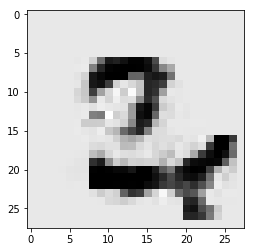

In [29]:
#Variable to hold sample image from trained generator
sample_image = generator(z_placeholder, 1, z_dimensions, True)
#Create noise vector
z_batch = np.random.normal(-1, 1, size=[1, z_dimensions])
#Generate a temp image
temp = (sess.run(sample_image, feed_dict={z_placeholder: z_batch}))
#Plot the generated image in grayscale
my_i = temp.squeeze()
plt.imshow(my_i, cmap='gray_r')
plt.show()